<a href="https://colab.research.google.com/github/kobrue02/evaluating-llm-generated-nlu-data/blob/main/bin/notebooks/evaluate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/kobrue02/evaluating-llm-generated-nlu-data/
%cd evaluating-llm-generated-nlu-data

Cloning into 'evaluating-llm-generated-nlu-data'...
remote: Enumerating objects: 1049, done.
remote: Counting objects: 100% (165/165), done.
remote: Compressing objects: 100% (122/122), done.
remote: Total 1049 (delta 91), reused 103 (delta 43), pack-reused 884 (from 1)
Receiving objects: 100% (1049/1049), 10.37 MiB | 24.53 MiB/s, done.
Resolving deltas: 100% (689/689), done.
/content/evaluating-llm-generated-nlu-data


In [2]:
import json
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

In [3]:
from bin.utils.methods import *
from bin.framework.framework import Framework

In [4]:
import logging
logging.basicConfig(level=logging.INFO)

In [5]:
import nltk
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [6]:
dataset_names = [
    "attribute_controlled_prompt_data",
    "persona_based_prompt_s1_data",
    "chain_of_thought_simple_data",
    "zero_shot_simple_data",
    "one_shot_simple_data",
    "few_shot_simple_data",
]

In [8]:
ref_df = load_sipgate_dataset()

load phi data

In [9]:
phi_dfs = [load_df(f"phi/{dataset_name}") for dataset_name in dataset_names]

In [11]:
llama_dfs = [load_df(f"llama/llama_{dataset_name}") for dataset_name in dataset_names]

In [21]:
framework = Framework()
evaluated_sets_phi = []
for gen_df in phi_dfs:
  gen_df = clean_synthetic_dataset(gen_df)
  results = framework.apply_framework_to_datasets(gen_df, ref_df)
  df = results_to_dataframe(results)
  evaluated_sets_phi.append(df)

 88%|████████▊ | 80/91 [00:25<00:05,  1.97it/s]/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 10%|▉         | 9/92 [00:02<00:21,  3.78it/s]/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 18%|█▊        | 17/92 [00:06<00:35,  2.11it/s]/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_

In [ ]:
dfs_to_stripplots(evaluated_sets_phi)

In [23]:
framework = Framework()
evaluated_sets_llama = []
for gen_df in llama_dfs:
  gen_df = clean_synthetic_dataset(gen_df)
  results = framework.apply_framework_to_datasets(gen_df, ref_df)
  df = results_to_dataframe(results)
  evaluated_sets_llama.append(df)

 43%|████▎     | 40/92 [00:21<00:08,  5.96it/s]/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 92/92 [00:24<00:00,  3.81it/s]


In [ ]:
dfs_to_stripplots(evaluated_sets_llama)

In [24]:
def merge_dataframes(evaluated_sets, dataset_names):
    """Merges a list of dataframes into a single dataframe with a new column indicating the prompting strategy.

    Args:
        evaluated_sets: A list of pandas DataFrames.
        dataset_names: A list of strings representing the prompting strategy names.

    Returns:
        A single pandas DataFrame with all data merged and a new "Prompting Strategy" column.
        Returns None if input lists are not of equal length or if any error occurs during processing.
    """
    if len(evaluated_sets) != len(dataset_names):
        print("Error: evaluated_sets and dataset_names must have the same length.")
        return None

    try:
        merged_df = pd.DataFrame()
        for i, df in enumerate(evaluated_sets):
            df['Prompting Strategy'] = dataset_names[i]
            merged_df = pd.concat([merged_df, df], ignore_index=True)
        return merged_df
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [25]:
merged_phi_df = merge_dataframes(evaluated_sets_phi, dataset_names)
merged_llama_df = merge_dataframes(evaluated_sets_llama, dataset_names)

In [26]:
concatenated_df = pd.concat([merged_phi_df, merged_llama_df], ignore_index=True)
concatenated_df["Model"] = ""  # Add a new column named "Model" initialized with empty strings
concatenated_df.loc[concatenated_df.index < len(merged_phi_df), "Model"] = "Phi"
concatenated_df.loc[concatenated_df.index >= len(merged_phi_df), "Model"] = "Llama"

In [27]:
ref_eval = framework.apply_framework_to_datasets(ref_df)

100%|██████████| 92/92 [00:05<00:00, 16.50it/s]


In [28]:
ref_eval_df = results_to_dataframe(ref_eval)
ref_eval_df["Prompting Strategy"] = "Sipgate"
ref_eval_df["Model"] = "Human"
concatenated_df = pd.concat([concatenated_df, ref_eval_df], ignore_index=True)

In [29]:
concatenated_df

,distinct_1,distinct_2,ttr,moving_average_ttr,average_n_of_tokens,average_n_of_characters,distance_to_centroid,discourse_coherence,inter_sentence_similarity,pos_tag_n_grams_diversity,bleu,mean_levenshtein_distance,intent,Prompting Strategy,Model
0,0.304,0.527,0.286,0.635,4.308,30.538,0.597,1.245,0.604,0.942,0.138,23.778,account_activate_item,attribute_controlled_prompt_data,Phi
1,0.401,0.745,0.386,0.902,7.880,48.720,0.630,0.857,0.568,0.734,1.000,39.360,account_activate_item_not_possible,attribute_controlled_prompt_data,Phi
2,0.201,0.388,0.201,0.898,7.160,42.520,0.633,1.197,0.554,0.846,0.272,30.054,account_ask_item_available,attribute_controlled_prompt_data,Phi
3,0.314,0.624,0.256,0.751,3.440,23.520,0.631,1.054,0.574,0.399,0.578,17.686,account_delete_item,attribute_controlled_prompt_data,Phi
4,0.333,0.500,0.281,0.764,5.182,29.364,0.613,1.560,0.563,0.894,0.682,21.473,account_get_item,attribute_controlled_prompt_data,Phi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1186,0.459,0.891,0.414,0.912,4.440,27.880,0.819,0.744,0.295,0.537,NaN,NaN,request_migrate_product,Sipgate,Human
1187,0.568,0.876,0.527,0.924,5.840,44.040,0.784,0.681,0.354,0.514,NaN,NaN,routing_set_time_profile,Sipgate,Human
1188,0.485,0.780,0.465,0.824,4.040,25.360,0.707,0.782,0.463,0.450,NaN,NaN,service_disruption_inquire,Sipgate,Human
1189,0.400,0.743,0.387,0.785,3.000,17.200,0.741,0.946,0.413,0.387,NaN,NaN,softphone_request_info,Sipgate,Human


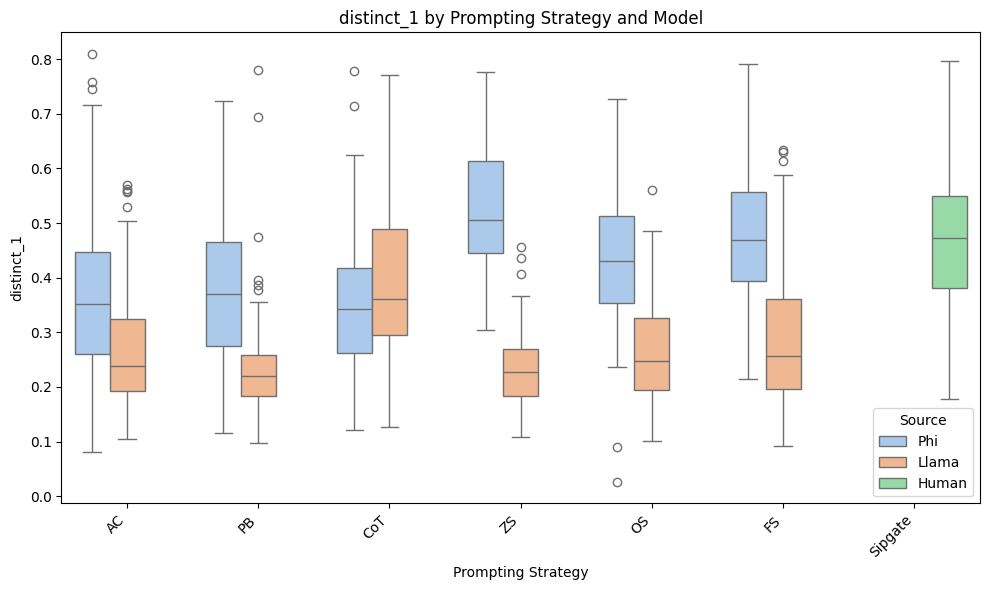

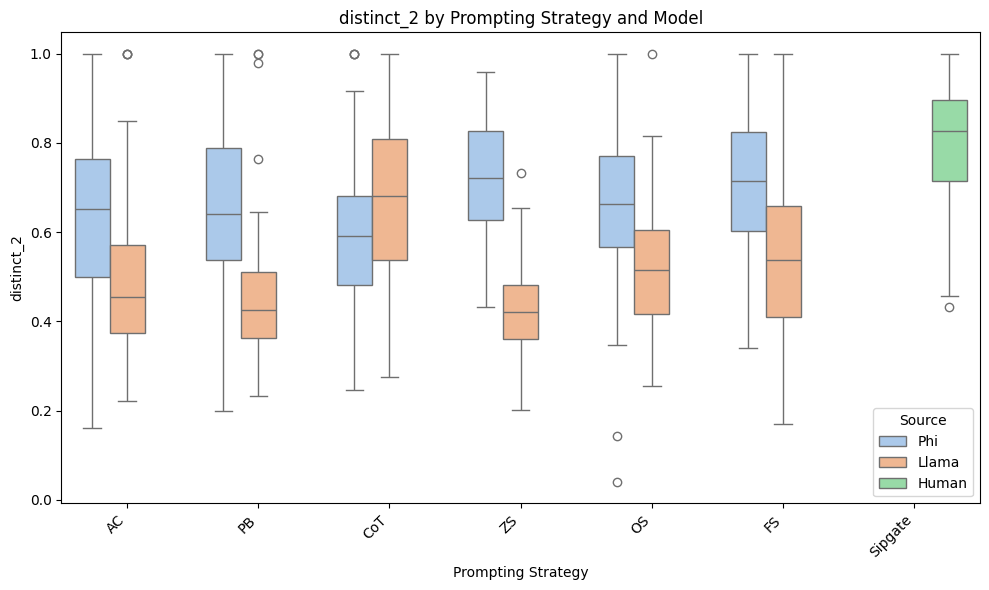

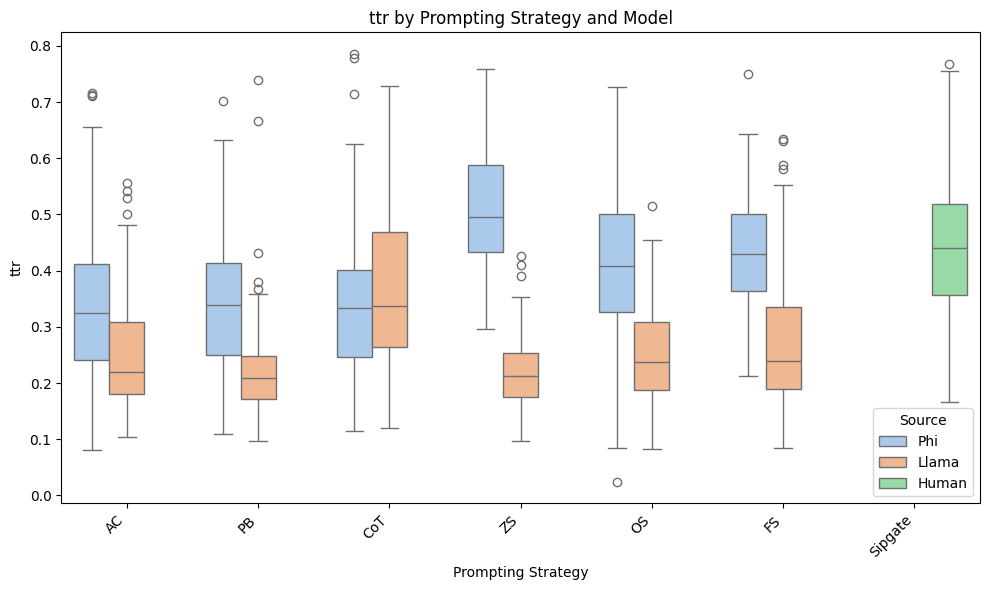

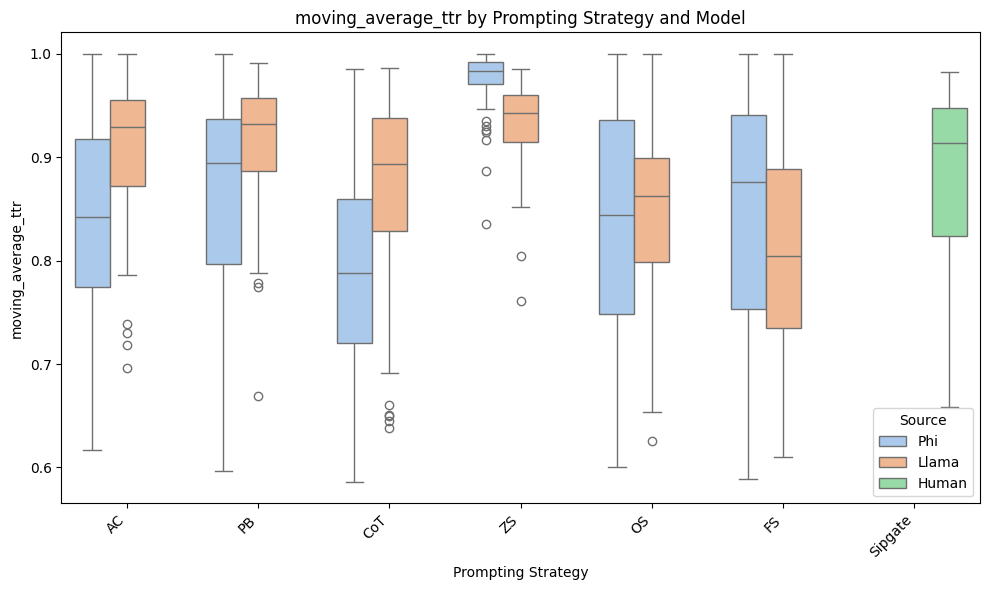

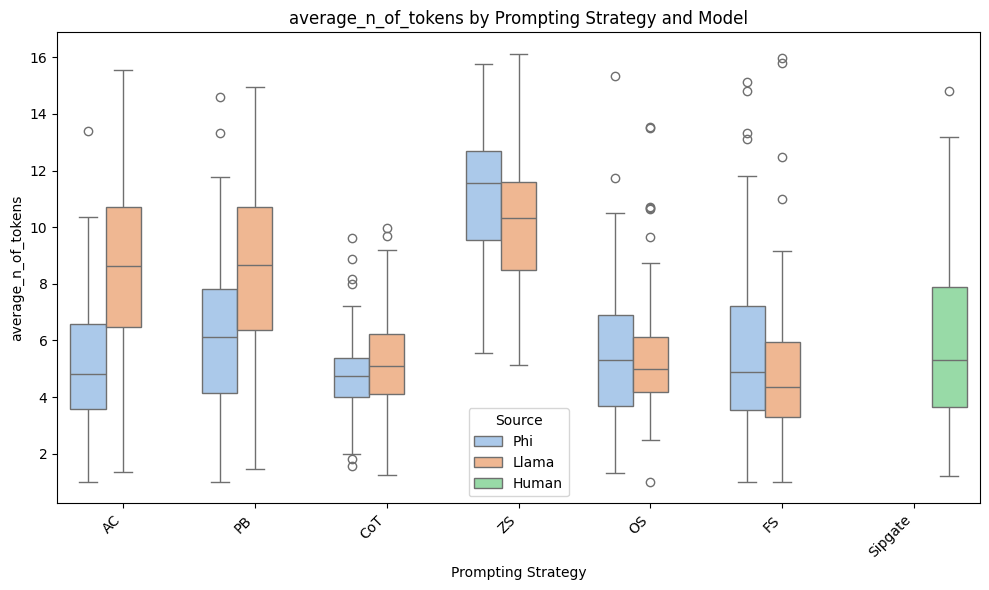

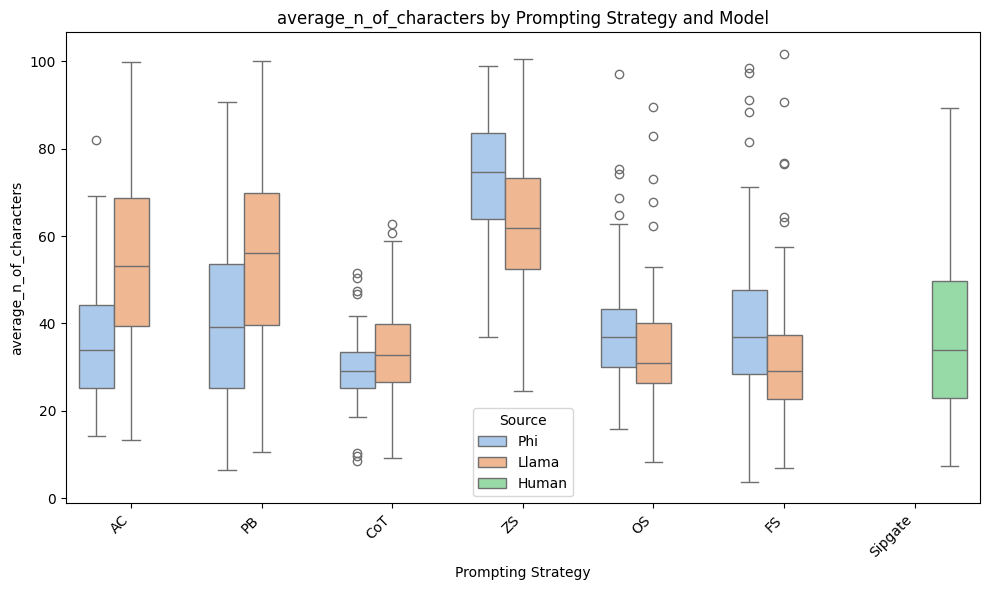

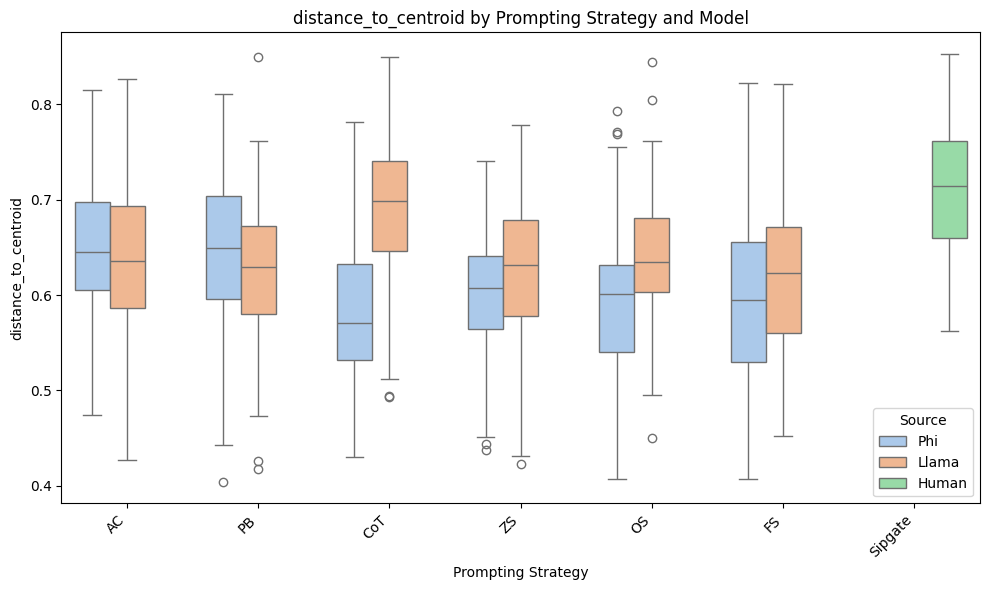

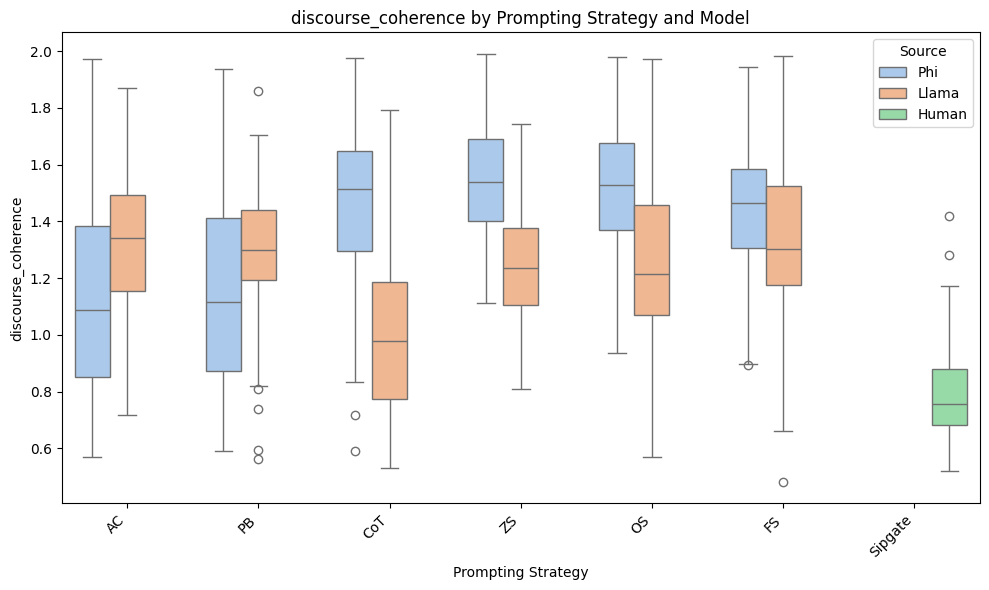

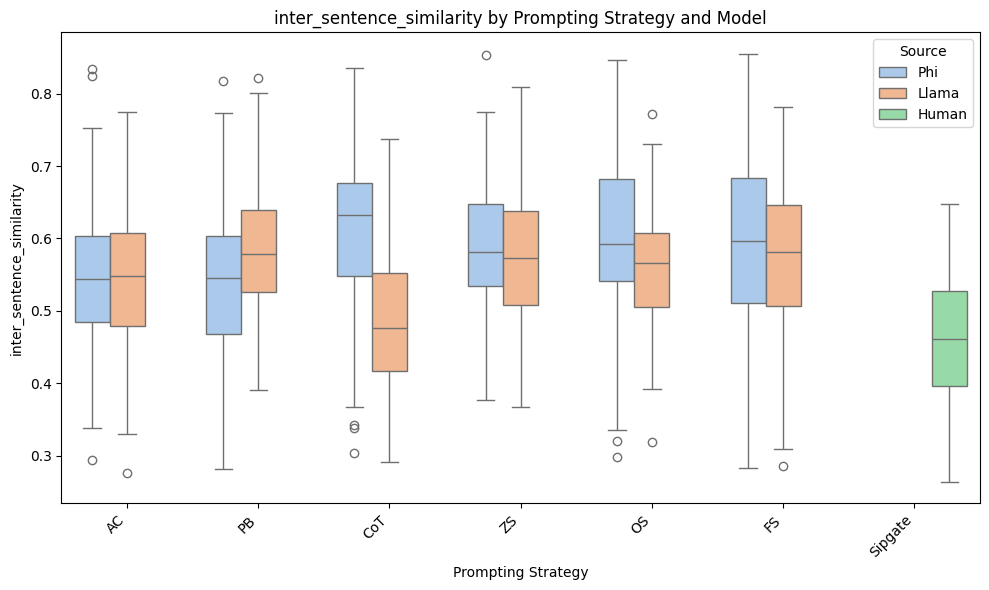

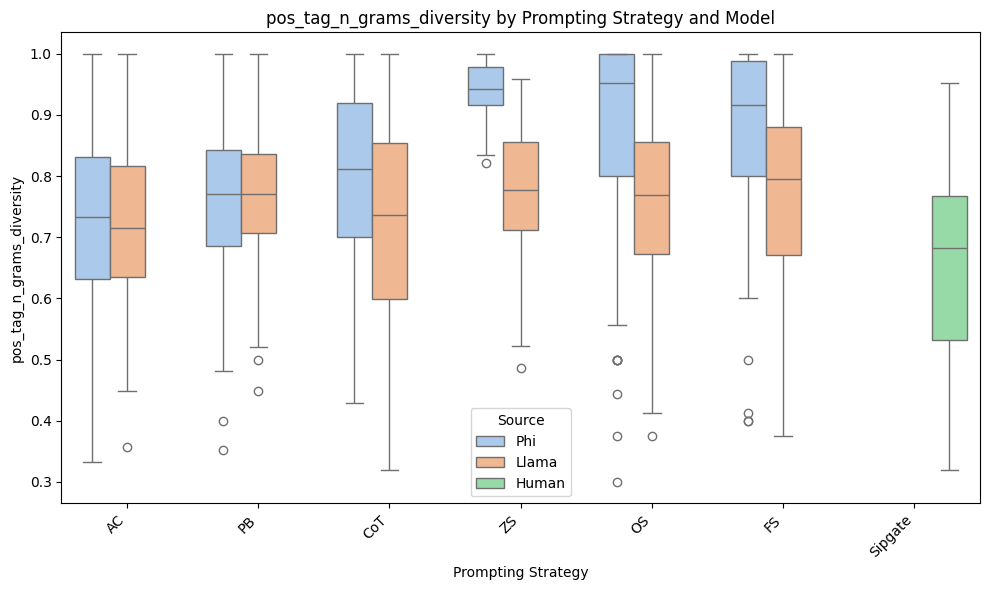

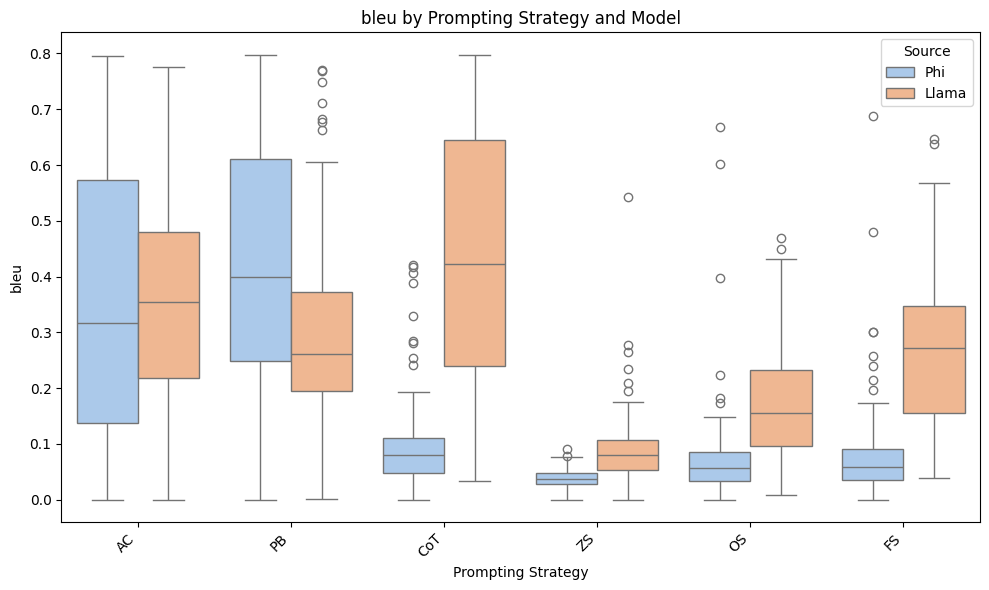

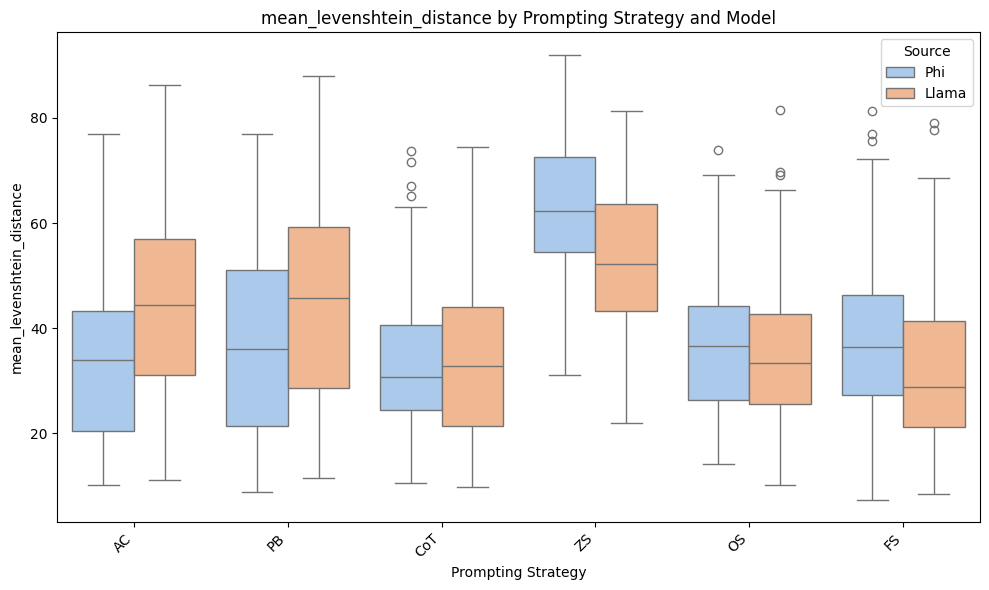

In [30]:
metrics = [col for col in concatenated_df.columns if col not in ["Prompting Strategy", "Model"]]

x_tick_dict = {
    "zero_shot_simple_data": "ZS",
    "one_shot_simple_data": "OS",
    "few_shot_simple_data": "FS",
    "chain_of_thought_simple_data": "CoT",
    "persona_based_prompt_s1_data": "PB",
    "attribute_controlled_prompt_data": "AC",
}

for metric in metrics:
    if metric in ["intent", "Dataset"]:
        continue

    plt.figure(figsize=(10, 6))

    # Remove extreme outliers
    q1 = concatenated_df[metric].quantile(0.25)
    q3 = concatenated_df[metric].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    temp_data = concatenated_df[(concatenated_df[metric] >= lower_bound) & (concatenated_df[metric] <= upper_bound)]

    # Create the boxplot
    ax = sns.boxplot(
        x="Prompting Strategy",
        y=metric,
        hue="Model",
        data=temp_data,
        palette="pastel"
    )

    # Rename each x-tick to its abbreviation
    current_labels = [t.get_text() for t in ax.get_xticklabels()]
    new_labels = [x_tick_dict.get(label, label) for label in current_labels]  # Default to original if not found
    plt.xticks(ticks=range(len(current_labels)), labels=new_labels, rotation=45, ha='right')

    # Rename the legend to "Source"
    plt.legend(title="Source")
    plt.title(f"{metric} by Prompting Strategy and Model")

    plt.tight_layout()
    plt.savefig(f"{metric}.png")
    plt.show()

In [65]:
from scipy.spatial.distance import jensenshannon
def js_divergence(p, q):
  p = np.asarray(p)
  q = np.asarray(q)
  return jensenshannon(p, q)